In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score,
    average_precision_score, auc
)

In [2]:
data_dir = os.path.join(os.getcwd(),'..','data')
dataset = pd.read_csv(os.path.join(data_dir, "feature_frame.csv"))

In [3]:
dataset.head(10)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
6,33826472919172,ricepastapulses,2808548917380,3476645445764,2020-10-06 14:23:08,2020-10-06 00:00:00,5,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
7,33826472919172,ricepastapulses,2808549900420,3437017956484,2020-10-06 14:24:26,2020-10-06 00:00:00,13,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
8,33826472919172,ricepastapulses,2808673927300,3539005440132,2020-10-06 17:57:23,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
9,33826472919172,ricepastapulses,2808728715396,3421126885508,2020-10-06 19:36:06,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


We already know from previous work in Module 2 and Module 3 that this dataset is really disbalanced.
More popular products are bought more often in general.

# Milestone 1: exploration phase
- Filter the data to only those orders with 5 items or more
- Seek to find the best model (linear or non-linear) with different parametrisations and regularisation.

In [4]:
def relevant_dataset(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    order_size = df.groupby("order_id").outcome.sum()
    orders_min = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_min)]

In [5]:
data = relevant_dataset(dataset, 5)

In [6]:
# Quick adjustment to time columns
data = data.assign(created_at = lambda x: pd.to_datetime(x.created_at))
data = data.assign(order_date = lambda x: pd.to_datetime(x.order_date).dt.date)

In [7]:
# Time-based split
daily_orders = data.groupby("created_at").order_id.nunique()
cumsum_orders = daily_orders.cumsum() / daily_orders.sum()
train_end = cumsum_orders[cumsum_orders <= 0.7].idxmax()
val_end = cumsum_orders[cumsum_orders <= 0.9].idxmax()

train = data[data["created_at"] <= train_end]
val = data[(data["created_at"]>train_end)&(data["created_at"]<=val_end)]
test = data[data["created_at"]> val_end]

### Baseline 
As we did in the previous module, we use a baseline model. In this case, the baseline is a linear model, which we compare against a non-linear model to justify the latter’s use.

### Linear model

In [8]:
feature_cols = ["user_order_seq", "ordered_before", "abandoned_before",
    "count_children", "count_babies", "count_pets",
    "people_ex_baby",
    "days_since_purchase_variant_id", "avg_days_to_buy_variant_id", "std_days_to_buy_variant_id",
    "days_since_purchase_product_type", "avg_days_to_buy_product_type", "std_days_to_buy_product_type"]

X_train = train[feature_cols]
X_val = val[feature_cols]

y_train = train["outcome"]
y_val = val["outcome"]

In [9]:
def plot_metrics(y_true, y_pred, model_name, fig_ax=None):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_true, y_pred)

    if fig_ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    else:
        fig, ax = fig_ax

    ax[0].plot(recall, precision, label=f"{model_name} PR AUC = {pr_auc:.2f}")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"{model_name} ROC AUC = {roc_auc:.2f}")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

    return fig, ax

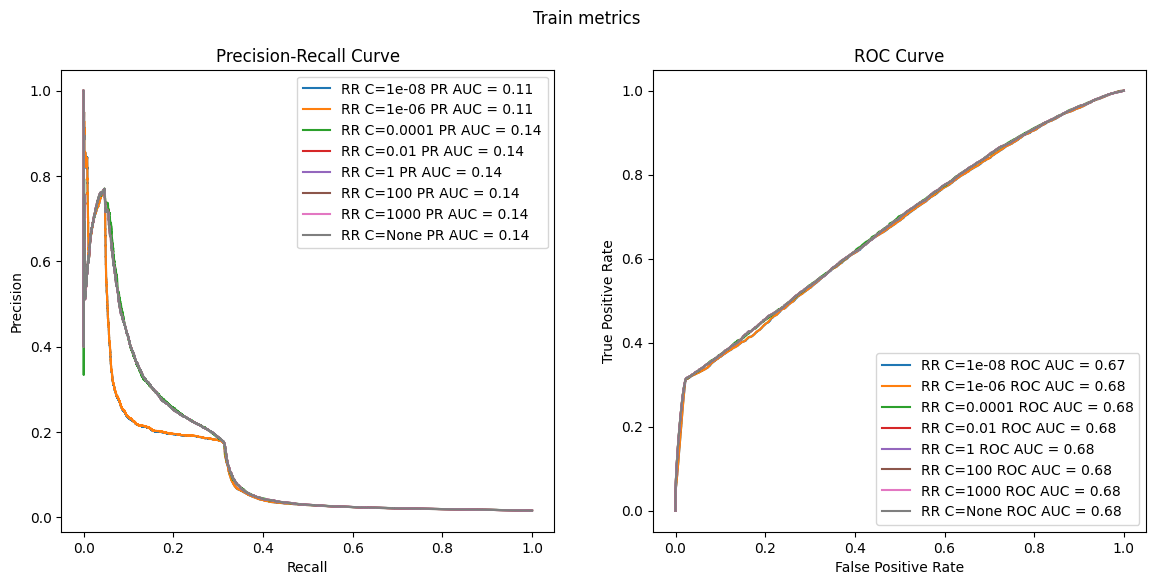

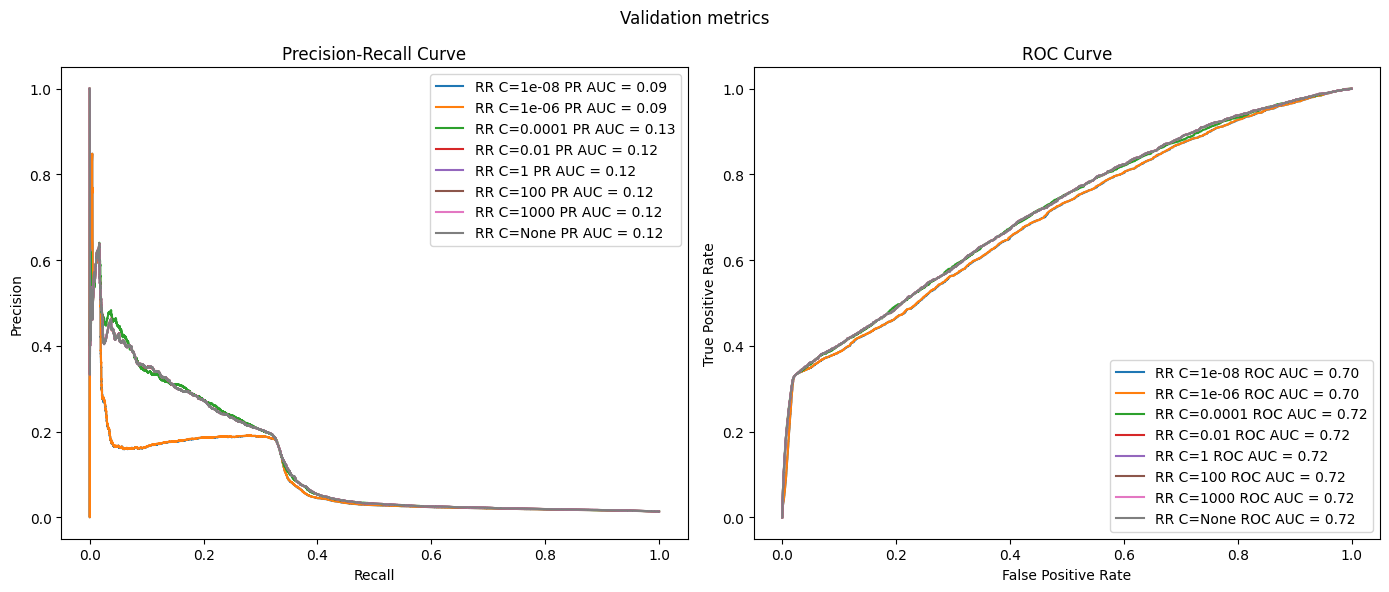

In [10]:
## RIDGE
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1000, None]  # Inverso de alpha

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 6))
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6))
fig1.suptitle("Train metrics")
fig2.suptitle("Validation metrics")

for c in cs:
    model = make_pipeline(
        StandardScaler(), 
        LogisticRegression(penalty='l2', C=c if c else 1.0, max_iter=1000, solver='lbfgs', random_state=42)
    )

    #FIT
    model.fit(X_train, y_train)

    # Train predictions
    train_proba = model.predict_proba(X_train)[:, 1]
    plot_metrics(y_train, train_proba, f"RR C={c}", fig_ax=(fig1, ax1))

    # Validation predictions
    val_proba = model.predict_proba(X_val)[:, 1]
    plot_metrics(y_val, val_proba, f"RR C={c}", fig_ax=(fig2, ax2))


plt.tight_layout()
plt.show()


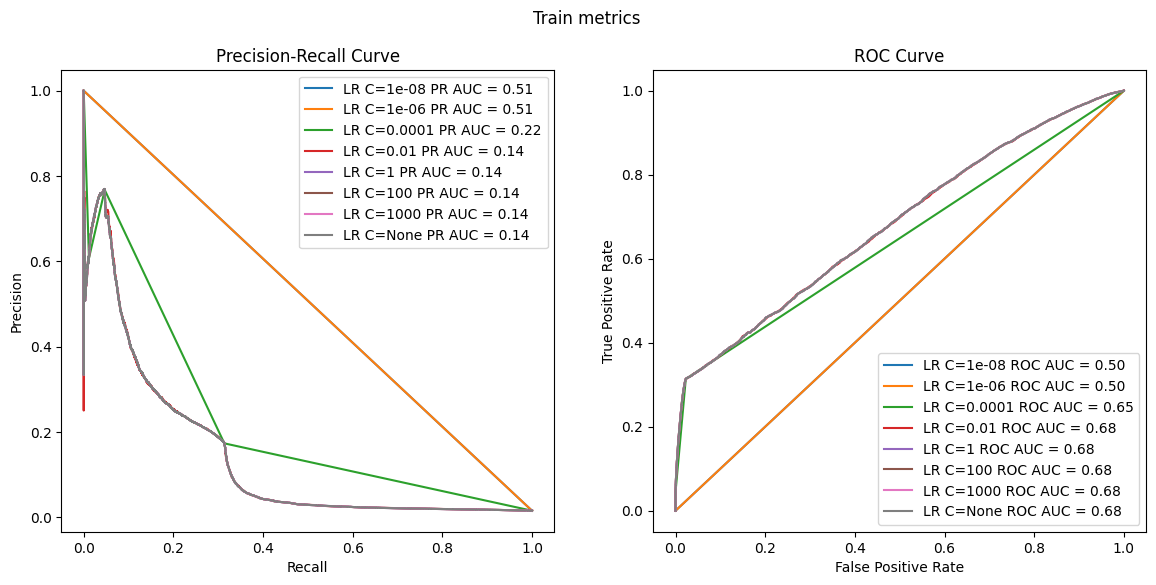

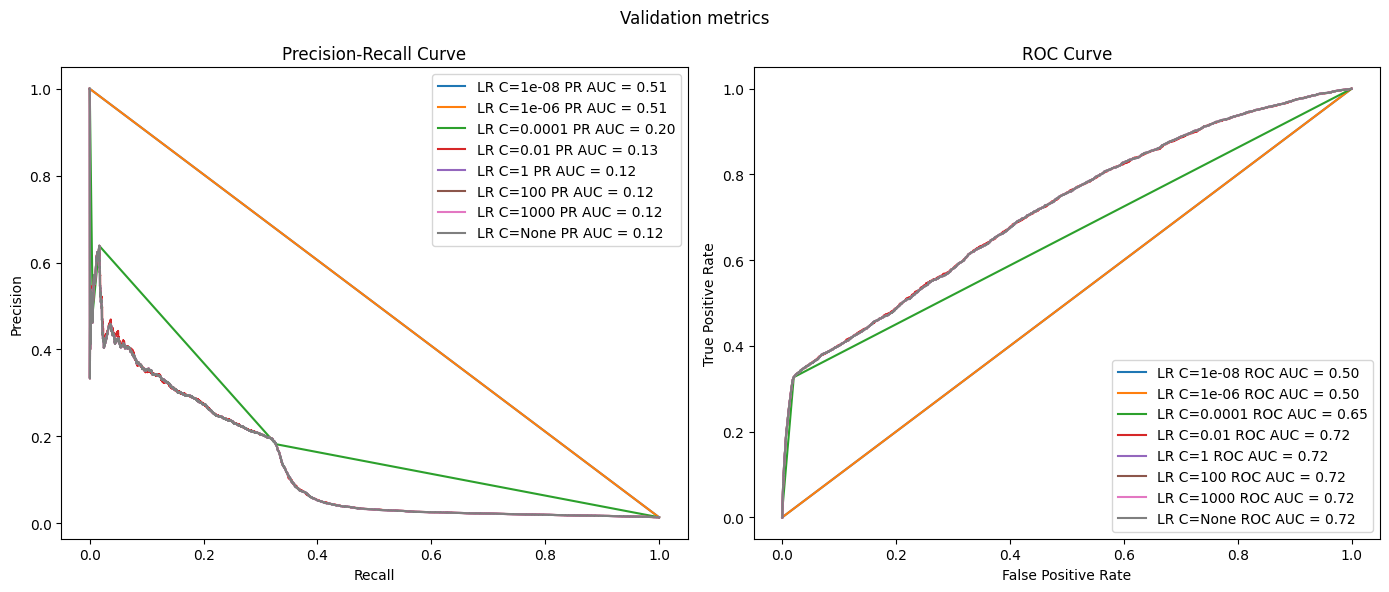

In [11]:
# Lasso
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1000, None]  # Inverso de alpha

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 6))
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6))
fig1.suptitle("Train metrics")
fig2.suptitle("Validation metrics")

for c in cs:
    model = make_pipeline(
        StandardScaler(), 
        LogisticRegression(penalty='l1', C=c if c else 1.0, max_iter=1000, solver='saga', random_state=42)
    )

    #FIT
    model.fit(X_train, y_train)

    # Train predictions
    train_proba = model.predict_proba(X_train)[:, 1]
    plot_metrics(y_train, train_proba, f"LR C={c}", fig_ax=(fig1, ax1))

    # Validation predictions
    val_proba = model.predict_proba(X_val)[:, 1]
    plot_metrics(y_val, val_proba, f"LR C={c}", fig_ax=(fig2, ax2))


plt.tight_layout()
plt.show()

### Non-Linear model

#### Decision tree

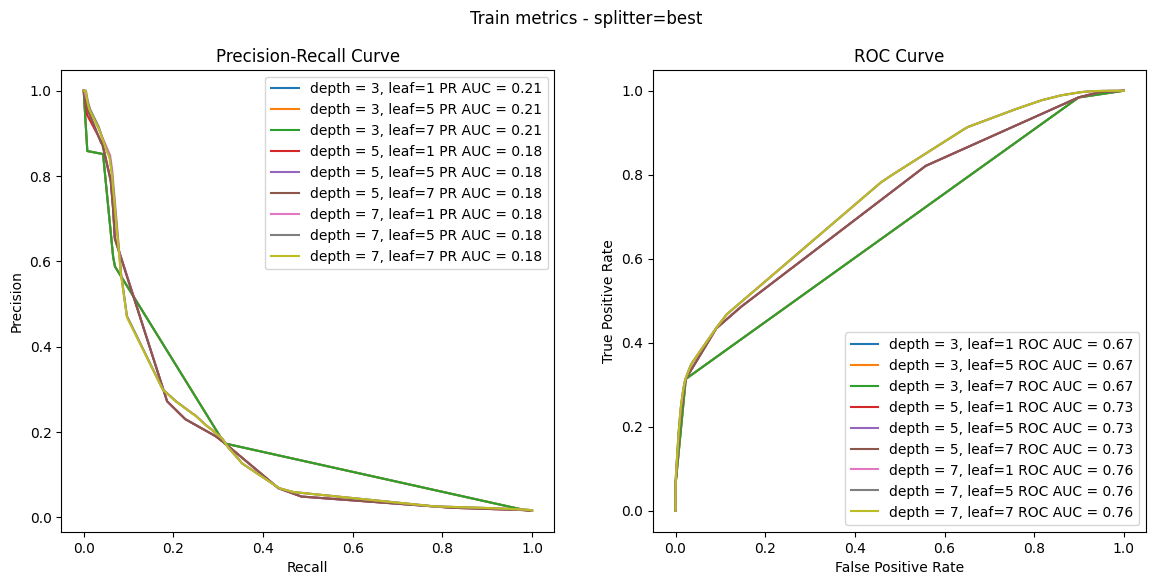

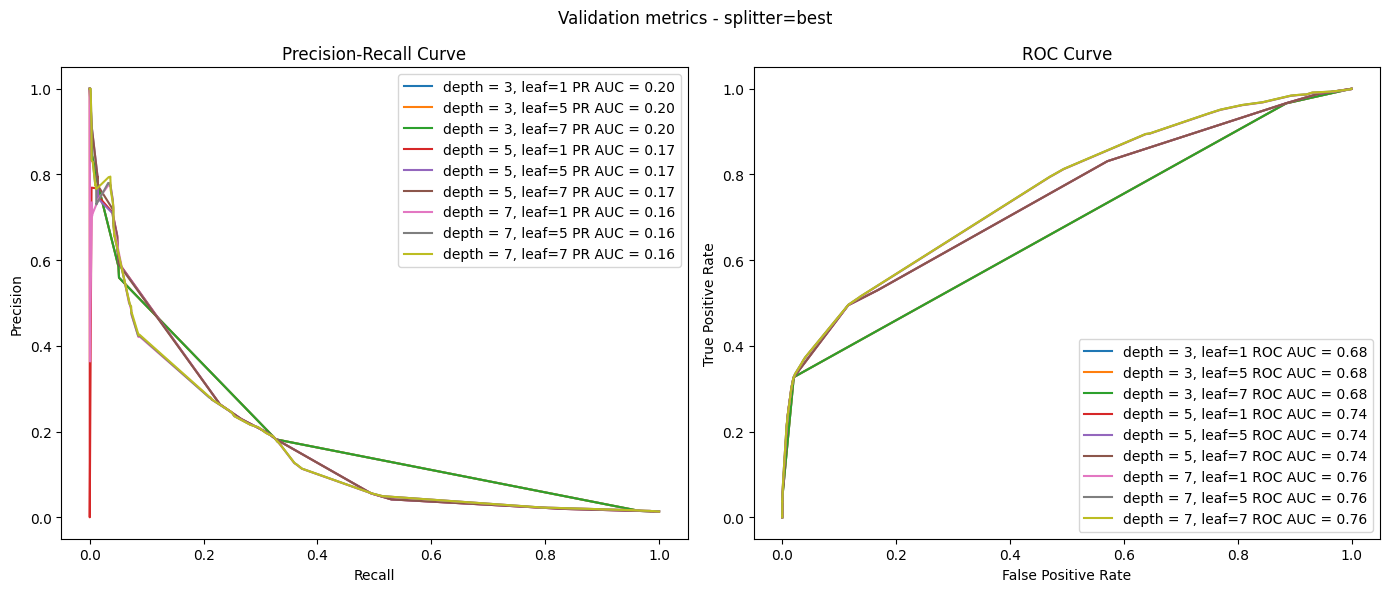

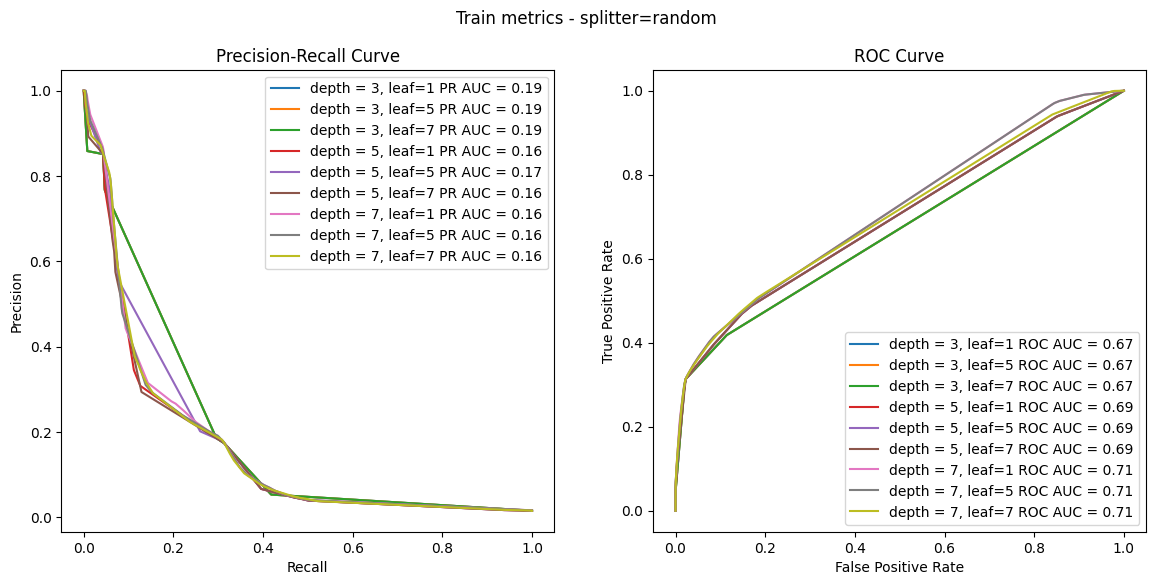

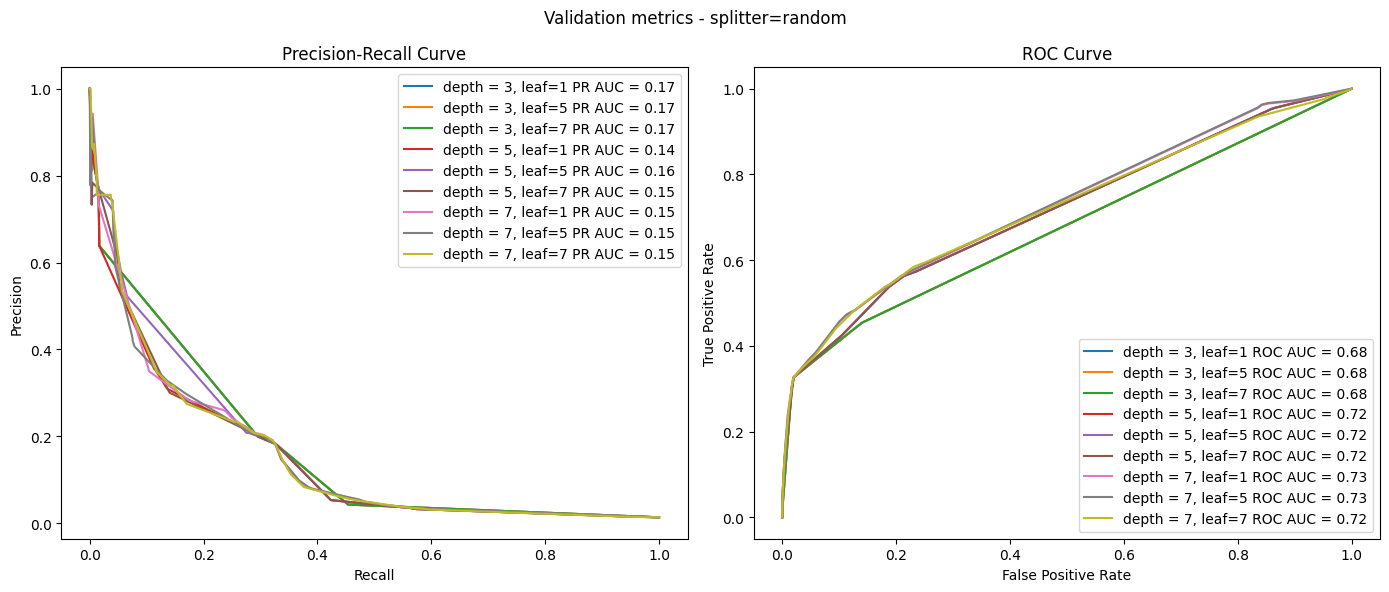

In [12]:
from sklearn.tree import DecisionTreeClassifier

splitters = ["best", "random"]
depths = [3, 5, 7]
min_leaves = [1,5,7]

for splitter in splitters:
    fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 6))
    fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 6))
    fig_train.suptitle(f"Train metrics - splitter={splitter}")
    fig_val.suptitle(f"Validation metrics - splitter={splitter}")
    for max_depth in depths:
        for min_samples_leaf in min_leaves:
            label = f"depth = {max_depth}, leaf={min_samples_leaf}"
            tree_clf = DecisionTreeClassifier(splitter=splitter,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42)

            tree_clf.fit(X_train,y_train)
            tree_train_proba = tree_clf.predict_proba(X_train)[:,1]
            tree_val_proba = tree_clf.predict_proba(X_val)[:,1]

            plot_metrics(y_train, tree_train_proba, label , fig_ax=(fig_train, ax_train))
            plot_metrics(y_val, tree_val_proba, label, fig_ax=(fig_val, ax_val))


    plt.tight_layout()
    plt.show()



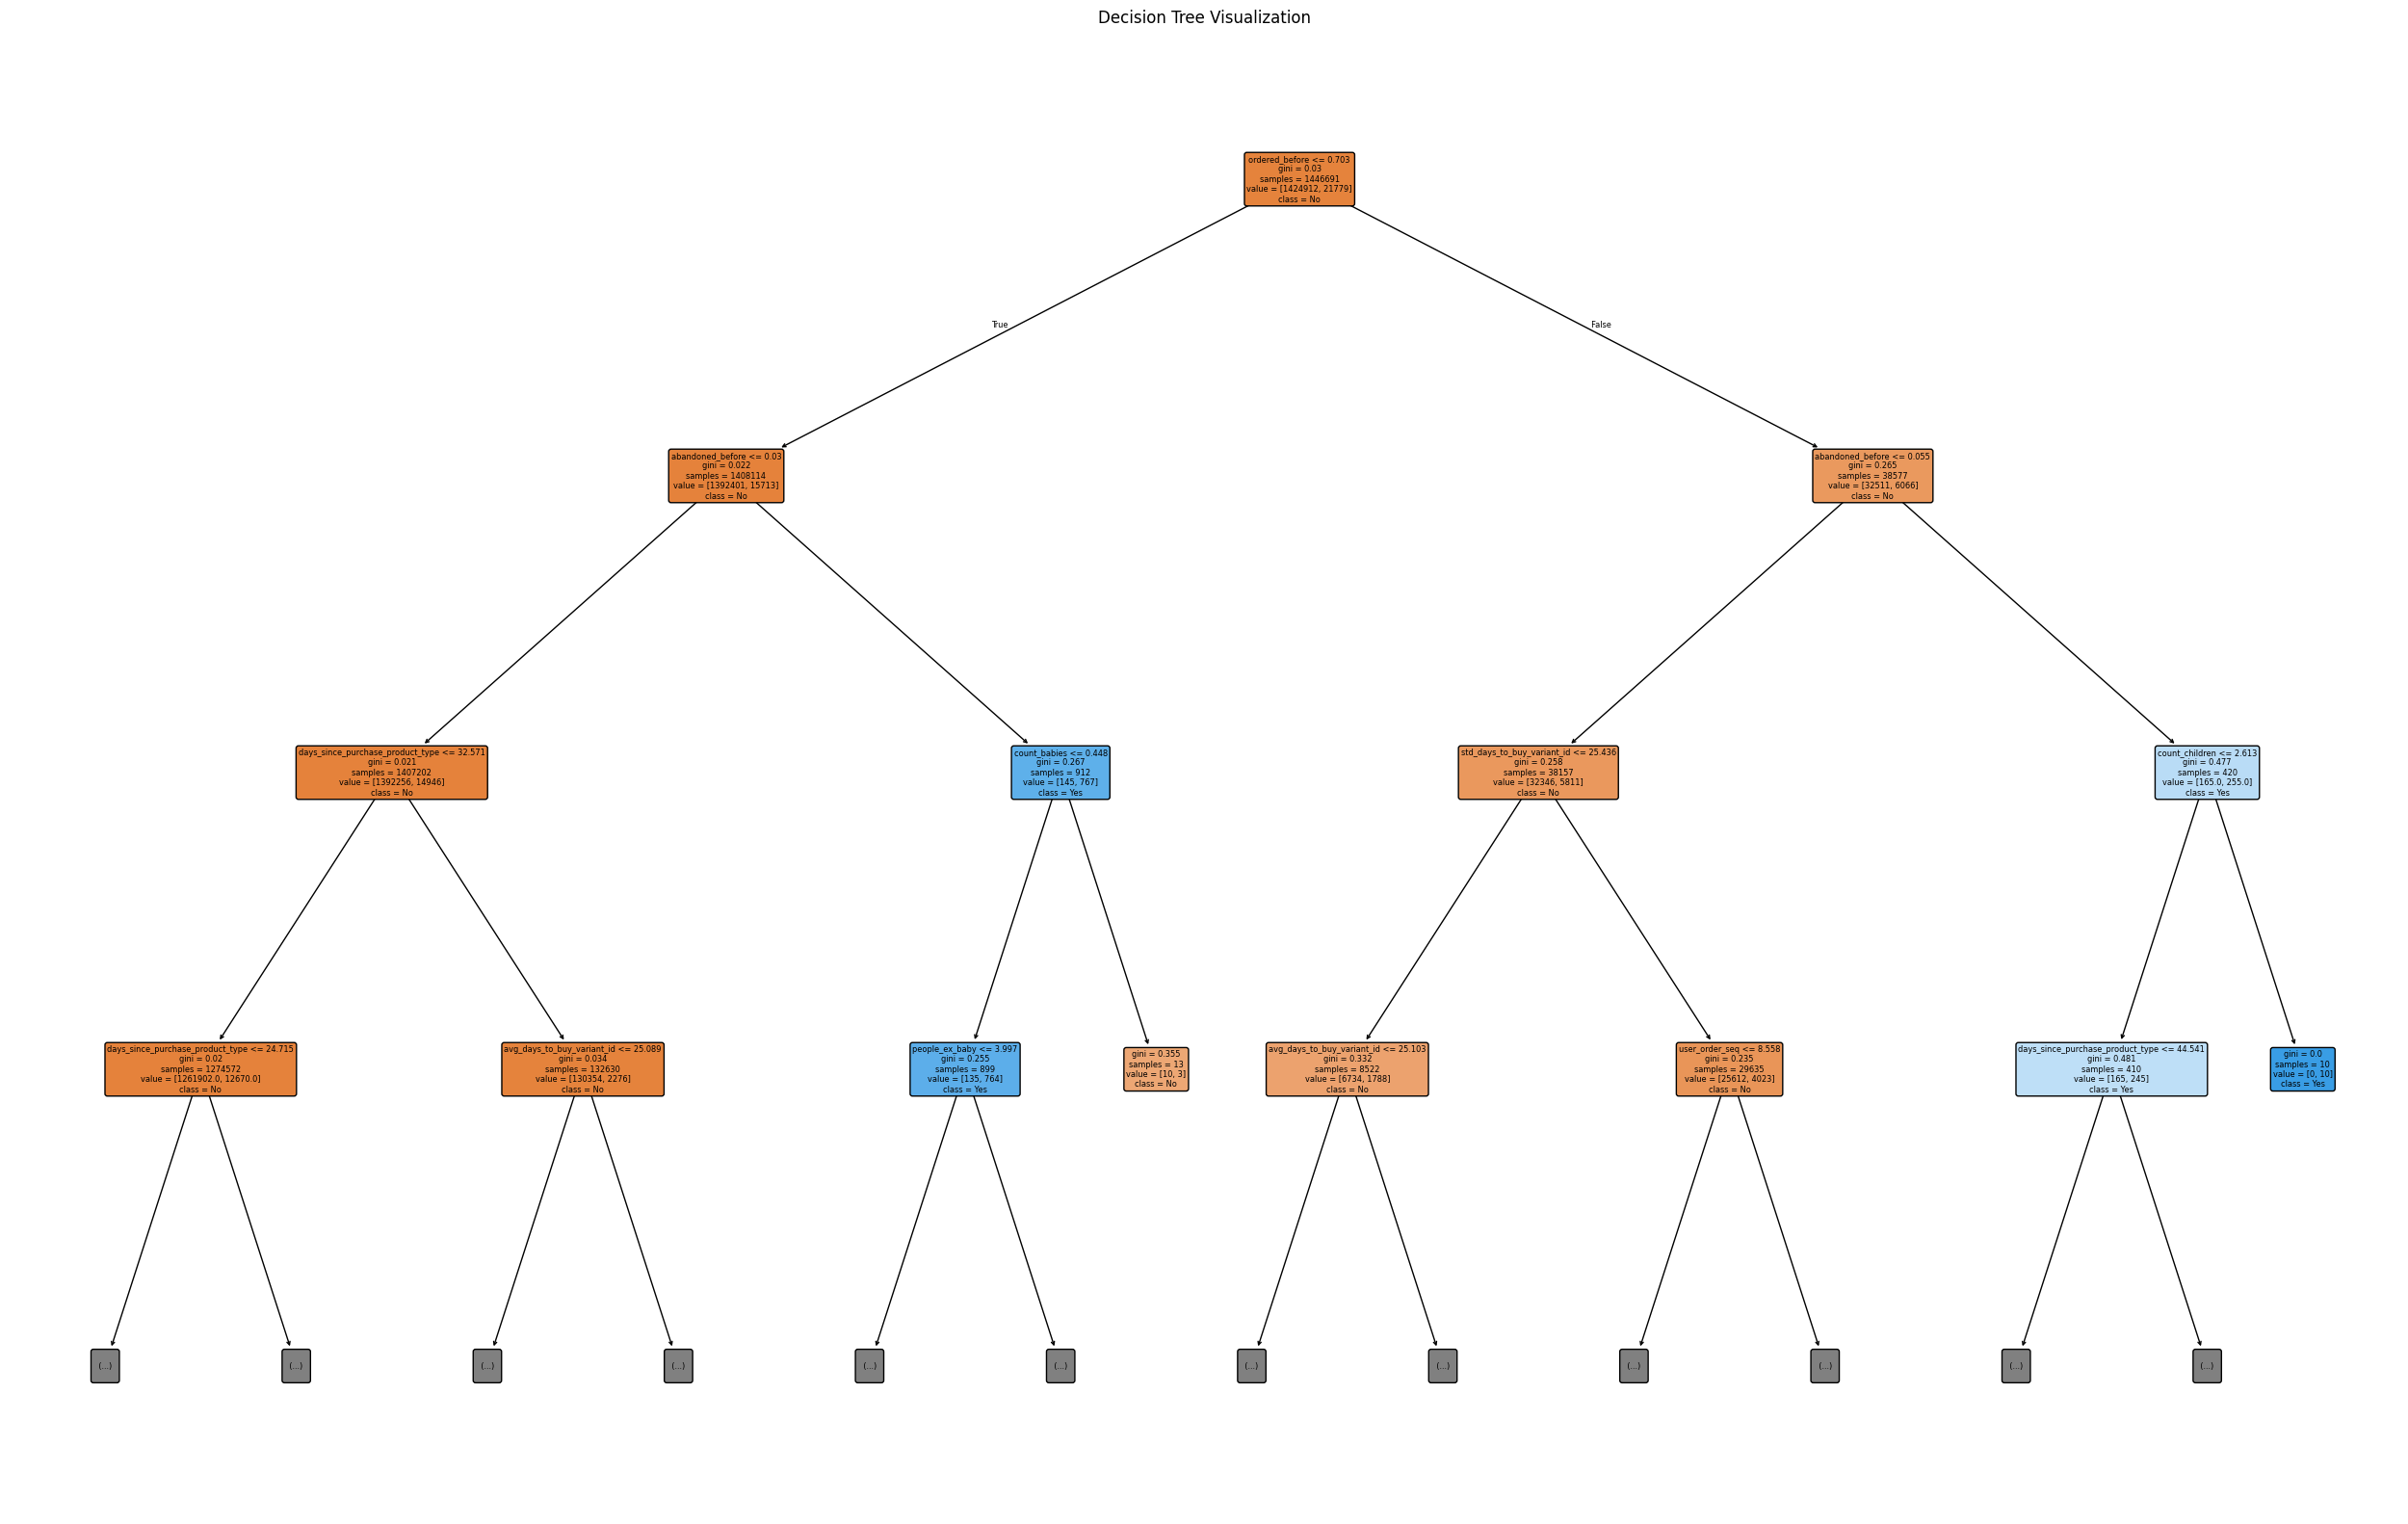

In [13]:
# Brief visualization of how tree is working
from sklearn import tree
plt.figure(figsize=(32, 20))
tree.plot_tree(
    tree_clf,
    filled=True,
    feature_names=X_train.columns,
    class_names=["No", "Yes"],
    rounded=True,
    max_depth=3
)
plt.title("Decision Tree Visualization")
plt.show()


After exploring various values of `max_depth`, `min_samples_leaf`, and both `splitter` types (`"best"` and `"random"`), the **Decision Tree model shows a slight improvement over linear models (Ridge and Lasso)** in terms of validation performance.

- The best-performing tree (`splitter="best"`, `max_depth=7`, `min_samples_leaf=1`) achieves a **ROC AUC of ~0.76** and a **PR AUC of ~0.20**.
- Linear models stabilize around **ROC AUC = 0.72** and **PR AUC = 0.12**, regardless of the regularization strength (`C`).
- The improvement in ROC AUC is modest but consistent, while the PR AUC gain is meaningful given the **class imbalance** of the dataset.

#### Ensembles

We begin with a simple bagging Random Forest

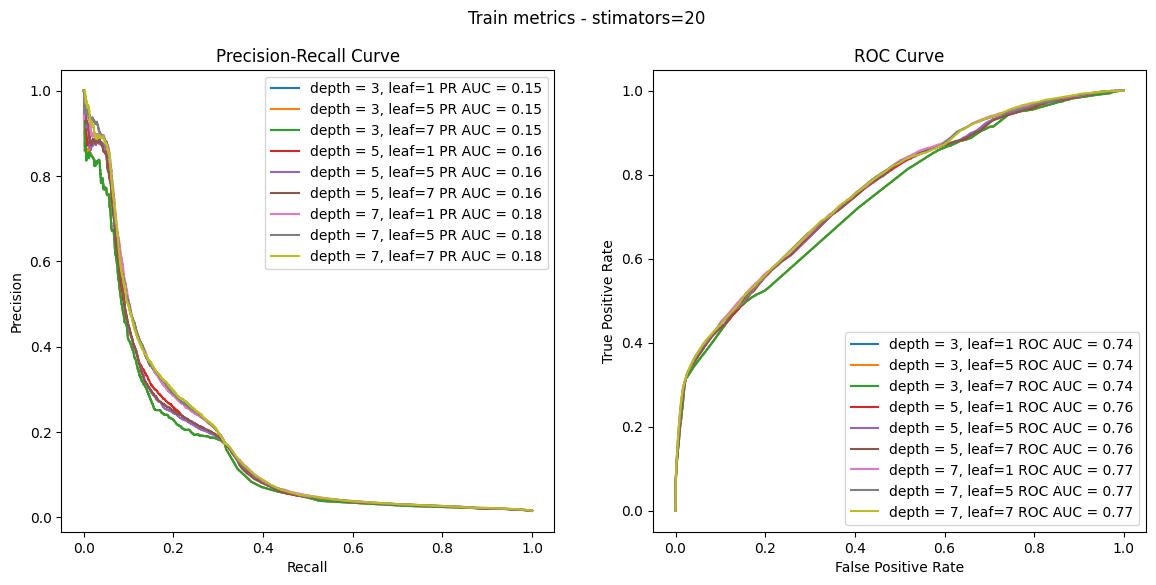

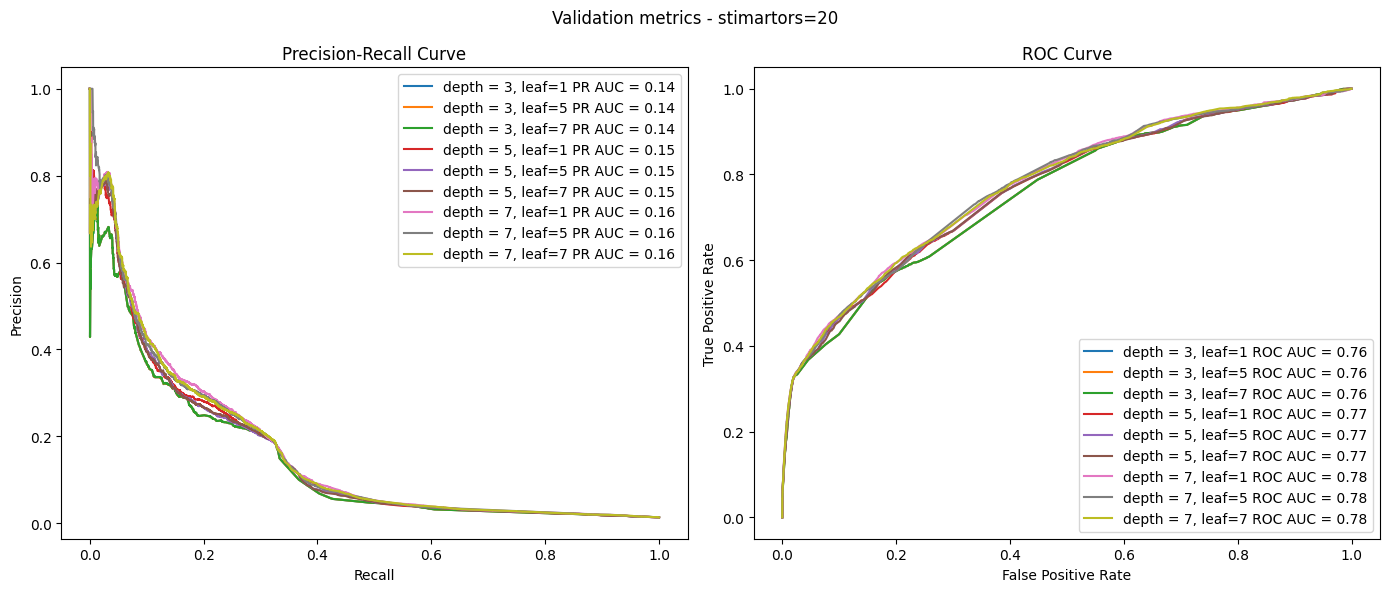

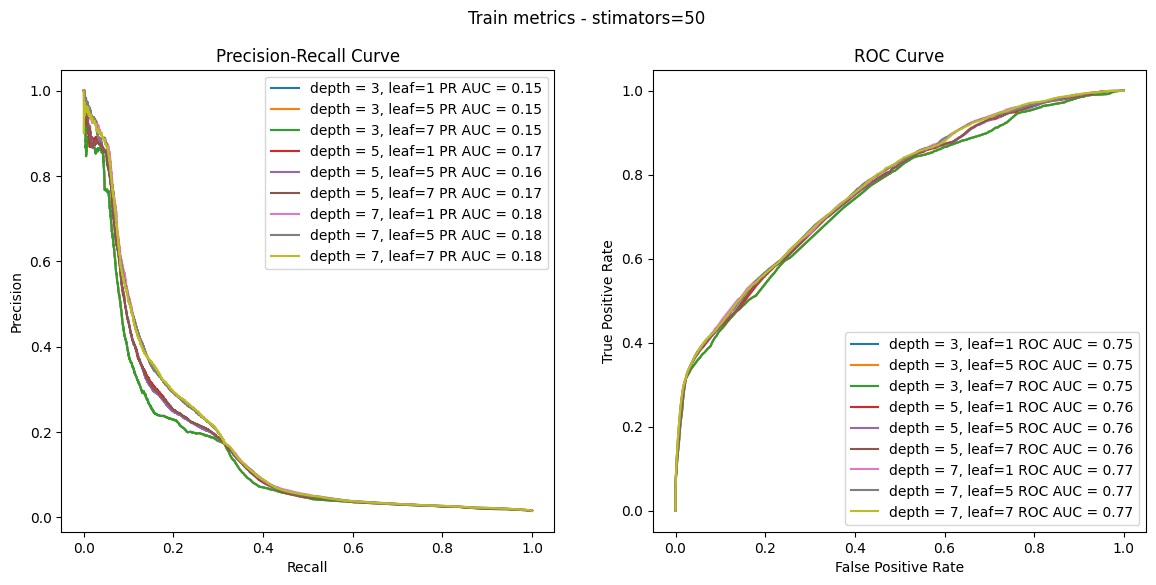

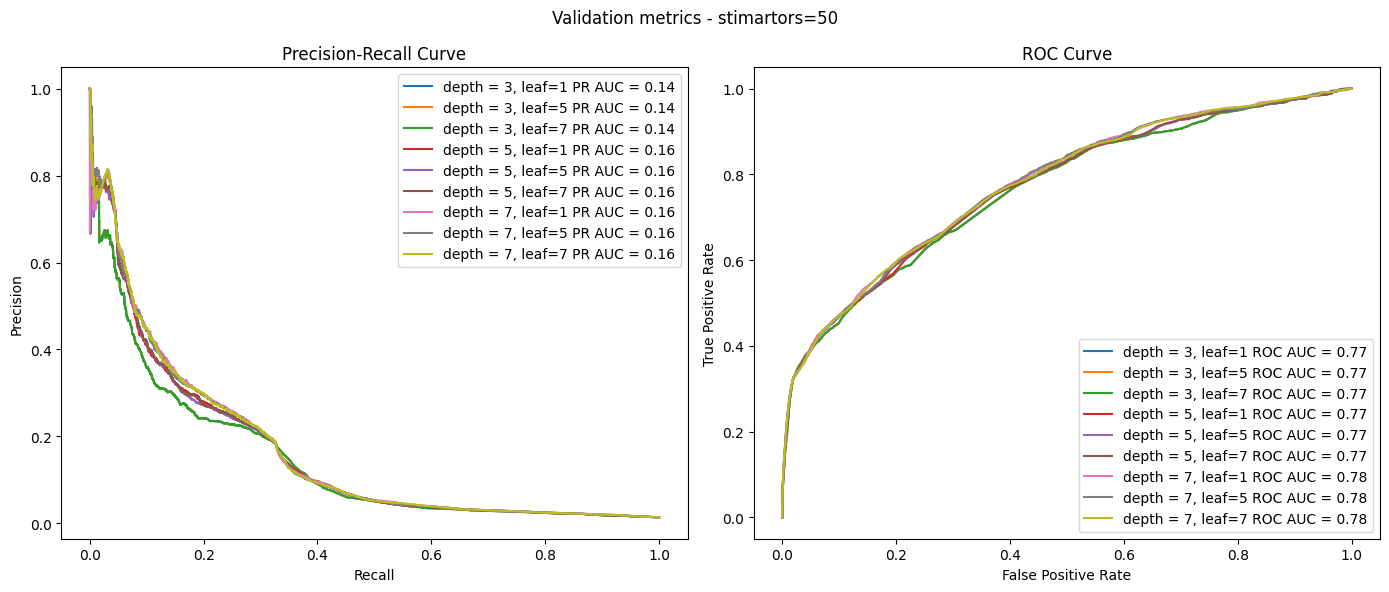

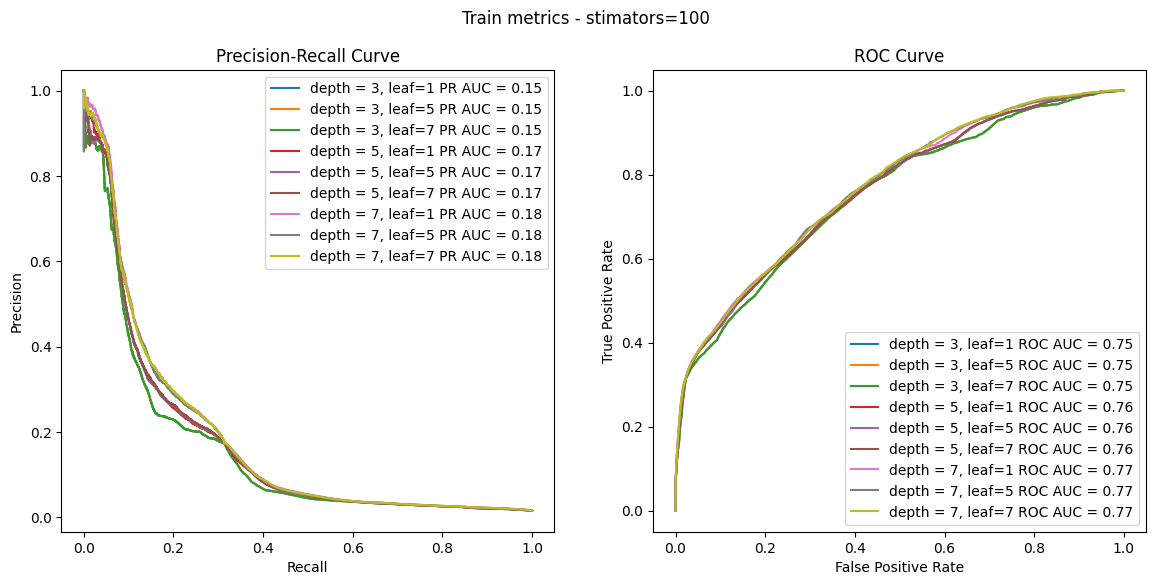

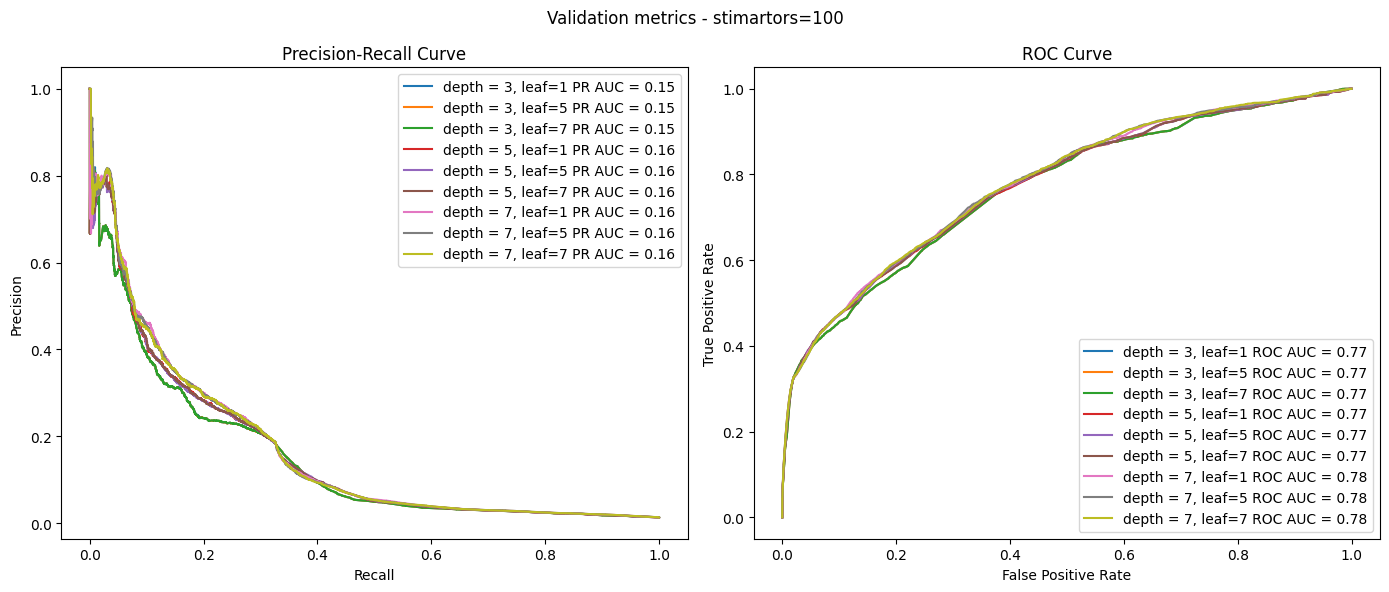

In [14]:
from sklearn.ensemble import RandomForestClassifier

stimators = [20, 50, 100]
depths = [3, 5, 7]
leaves = [1,5,7]

for n_stimators in stimators:
    fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 6))
    fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 6))
    fig_train.suptitle(f"Train metrics - stimators={n_stimators}")
    fig_val.suptitle(f"Validation metrics - stimartors={n_stimators}")
    for max_depth in depths:
        for min_samples_leaf in leaves:
            label = f"depth = {max_depth}, leaf={min_samples_leaf}"
            rf = RandomForestClassifier(
                n_estimators=n_stimators,
                max_depth = max_depth,
                max_features='sqrt',
                min_samples_leaf=min_samples_leaf,
                random_state=42,
                bootstrap = True, # Bagging
                n_jobs=-1)
            rf.fit(X_train,y_train)
            tree_train_proba = rf.predict_proba(X_train)[:,1]
            tree_val_proba = rf.predict_proba(X_val)[:,1]

            plot_metrics(y_train, tree_train_proba, label , fig_ax=(fig_train, ax_train))
            plot_metrics(y_val, tree_val_proba, label, fig_ax=(fig_val, ax_val))


    plt.tight_layout()
    plt.show()

A Random Forest model with varying `n_estimators`, `max_depth`, and `min_samples_leaf` shows **slightly better performance** than a single Decision Tree.

- **Validation ROC AUC** remains consistently high (~0.77–0.78).
- **PR AUC** improves modestly with more trees (~0.14 → ~0.16).
- Changes in `min_samples_leaf` or `max_depth` have minimal impact beyond a certain point.
- **Train and validation curves are close**, showing good generalization and low variance.

**Conclusion:** Random Forest brings a small but consistent improvement over Decision Trees, though the gain is not dramatic.

#### Gradient Booting

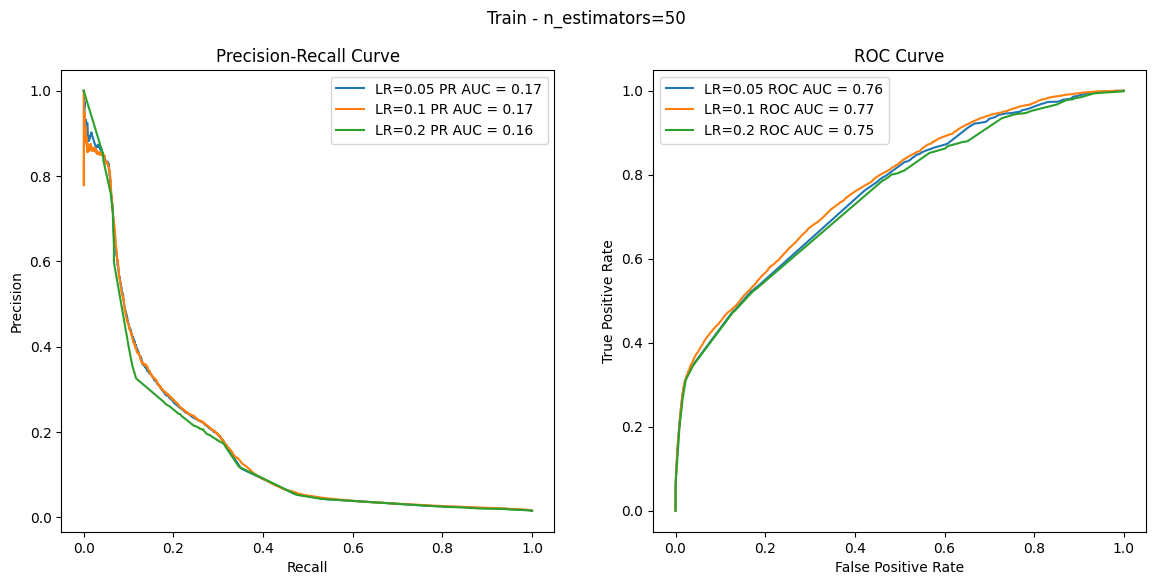

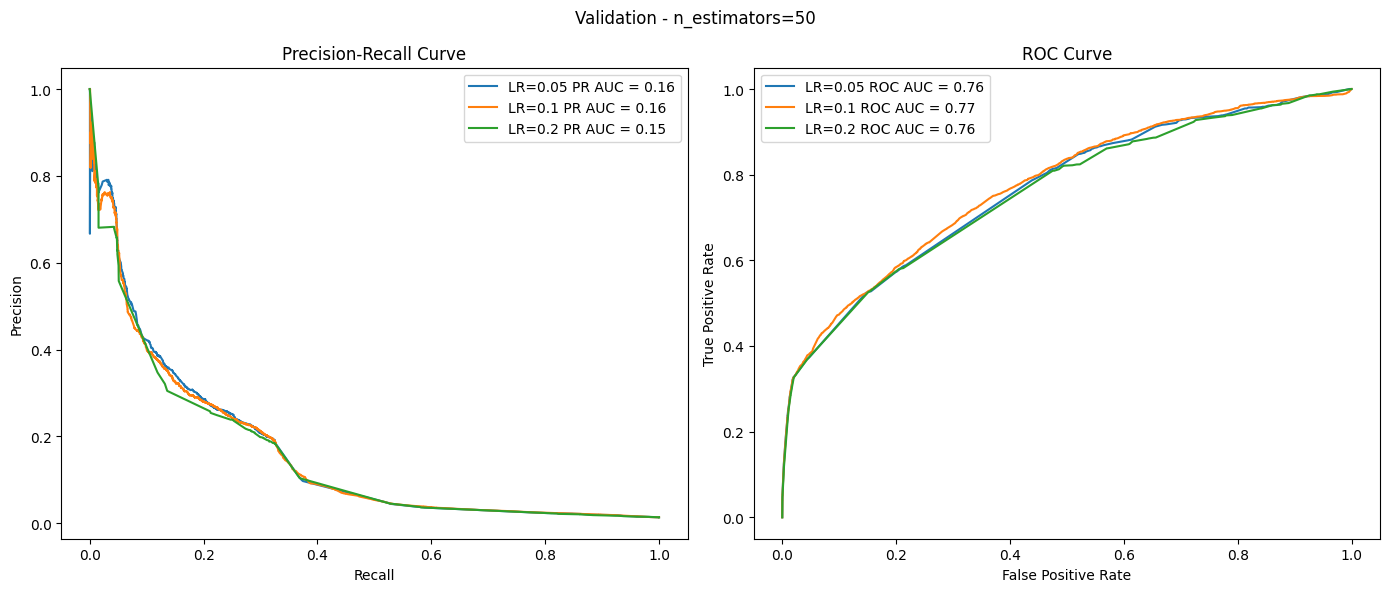

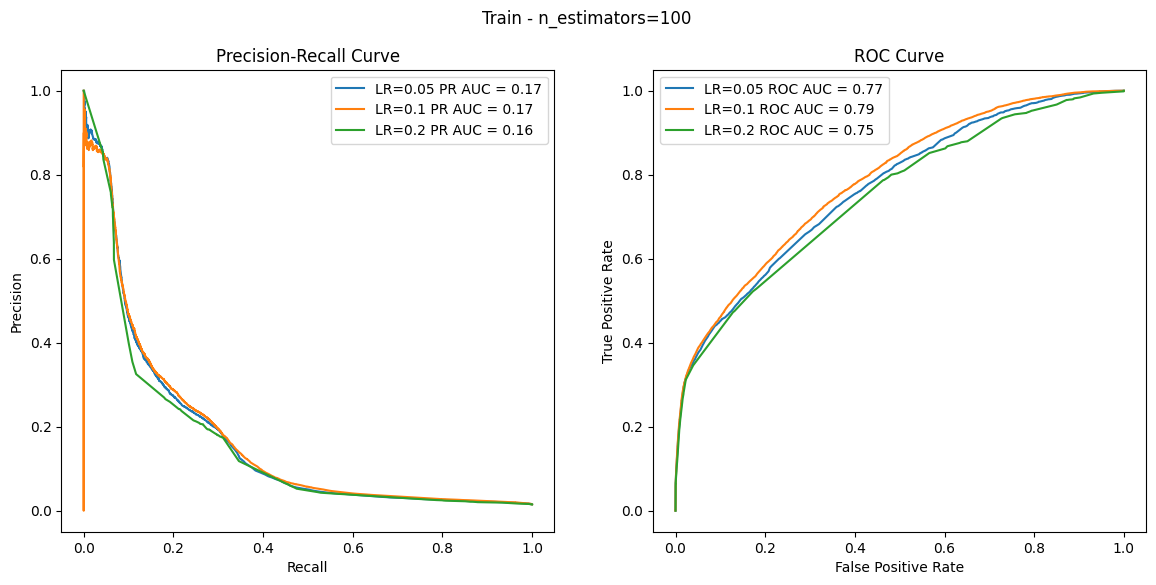

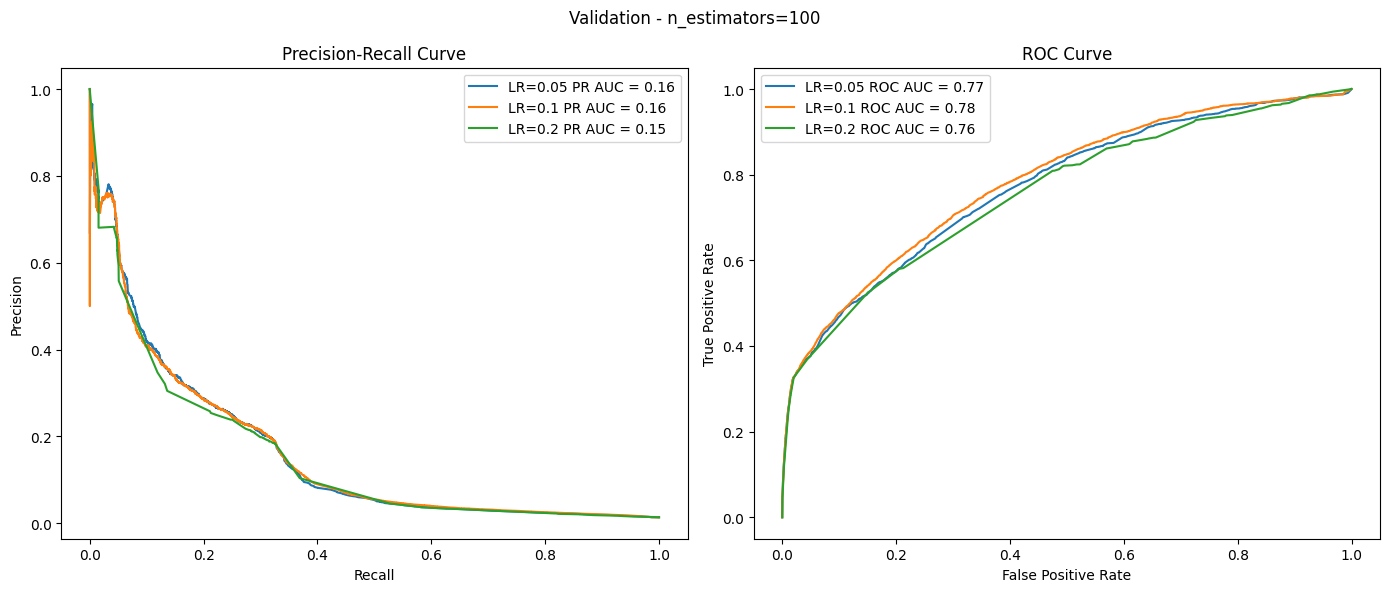

In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier
# Hist is faster than Gradient

n_estimators_list = [50, 100]
learning_rates = [0.05, 0.1, 0.2]
max_depth = 3 

for n_estimators in n_estimators_list:
    fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 6))
    fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 6))
    fig_train.suptitle(f"Train - n_estimators={n_estimators}")
    fig_val.suptitle(f"Validation - n_estimators={n_estimators}")

    for lr in learning_rates:
        label = f"LR={lr}"

        gb = HistGradientBoostingClassifier(
            max_iter=n_estimators,
            learning_rate=lr,
            max_depth=max_depth, 
            random_state=42
        )

        gb.fit(X_train, y_train)

        train_proba = gb.predict_proba(X_train)[:, 1]
        val_proba = gb.predict_proba(X_val)[:, 1]

        plot_metrics(y_train, train_proba, label, fig_ax=(fig_train, ax_train))
        plot_metrics(y_val, val_proba, label, fig_ax=(fig_val, ax_val))


    plt.tight_layout()
    plt.show()

`HistGradientBoostingClassifier` achieves performance that is **comparable or only slightly better than Random Forest in ROC AUC**, but it **does not significantly improve PR AUC**.

Given the small gains and increased complexity, **its use is not clearly justified in this case**, especially considering training time and model interpretability.

# Final Conclusions
Across all models tested, **Random Forest provides the best trade-off** between performance, generalization, and model complexity.

- It consistently achieves **ROC AUC ~0.78** and **PR AUC ~0.16** on the validation set.
- **Gradient Boosting (Hist)** performs similarly but adds more training time and complexity, without significant gains.
- **Decision Trees** perform well on PR AUC but are less stable.
- **Linear models** fall short in both ROC and PR metrics.

**Conclusion:** Random Forest Classifier is the best-performing and most balanced model for this problem, concretly the one with:
 - **n_estimators = 100**
 - **max_depth = 7**
 - **min_samples_leaf = 7**